In [1]:
import numpy as np
import scipy.sparse as sps
import porepy as pp

In [2]:
import sys
sys.path.append("./class")
from Transport_class import Transport

/home/dell/anaconda3/lib/python3.8/site-packages/porepy/viz/plot_grid.py:241: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_zlim3d(z)


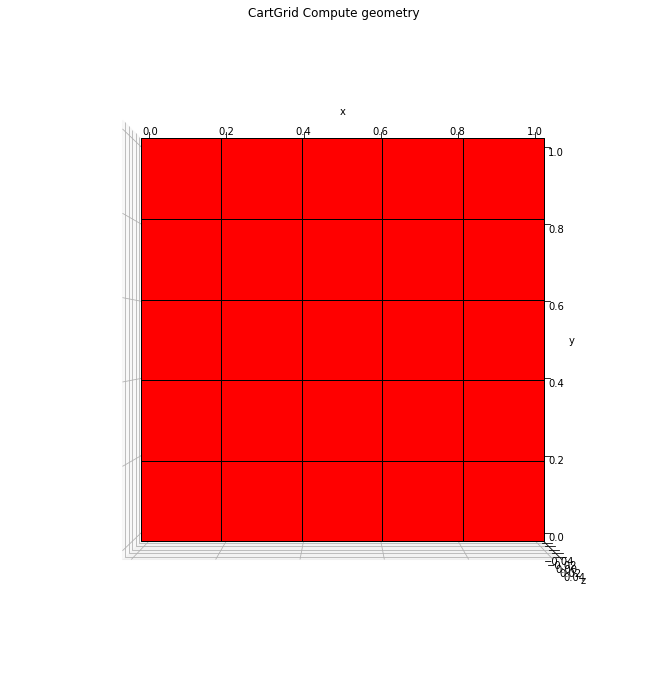

In [3]:
Nx=5
Ny=5
phys_dims=[1,1]
g=pp.CartGrid([Nx,Ny],phys_dims)
g.compute_geometry()        
pp.plot_grid(g, figsize=(15,12))

In [4]:
unity = np.ones(g.num_cells)
empty = np.empty(0)
#porosity=0.3*unity
porosity=unity
aperture=1
bc_type=["dir","dir"]
bc_value=[0.,0.]
#bc_value=[0.38553623, 0.]
#init_cond=lambda x,y,z:int(x<0.5)
init_cond=lambda x,y,z:int(x<0.2)
#init_cond=lambda x,y,z:0.0
#init_cond=lambda x,y,z:0.00545 
print(g.num_faces)

60


In [5]:
specified_parameters = {
            "bc_type": bc_type,
            "bc_value": bc_value,
            #"time_step": 34.56,
            "time_step": 0.01,
            "mass_weight": porosity * aperture,
            "darcy_flux":np.zeros(g.num_faces),
            #"darcy_flux":6.67e-9*np.ones(Nx+1),
            "t_max": 1,
            #"t_max":345600,
            "method": "Implicit",
            "lambda_lin_decay":0,
            "initial_cond":init_cond,
}

In [6]:
specified_parameters["darcy_flux"][:(Ny+1)*Nx]=1.
#print(specified_parameters["darcy_flux"])
vel=specified_parameters["darcy_flux"]

In [7]:
tracer=np.zeros(g.num_cells)
transport=Transport(g,specified_parameters)
#transport.set_bc()
#transport.set_initial_cond(tracer)
#lhs,rhs_b,rhs_matrix=transport.get_transport_lhs_rhs()
lhs,rhs_b,rhs_matrix=transport.set_and_get_matrices(tracer)
print(tracer)

[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0.]


In [8]:
IEsolver = sps.linalg.factorized(lhs)

data_transport=transport.data[pp.PARAMETERS]["transport"]
n_steps = int(np.round(data_transport["t_max"] / data_transport["time_step"]))

save_every=1

# Exporter
exporter = pp.Exporter(transport.g, file_name="tracer",folder_name="solution")
    
#for i in range(1,n_steps+1,1):
for i in range(1,2,1):
    if np.isclose(i % save_every, 0):
        # Export existing solution (final export is taken care of below)
        exporter.write_vtu({"tracer":tracer}, time_step=int(i // save_every))
        if data_transport["method"]=="Explicit":
            tracer = IEsolver(rhs_matrix*tracer+rhs_b)
            #print(tracer)
        else:
            tracer = IEsolver(rhs_matrix*tracer+rhs_b)
            #print(tracer)
print(tracer)
exporter.write_vtu({"tracer":tracer}, time_step=(n_steps // save_every))
time_steps = np.arange(0,data_transport["t_max"] + data_transport["time_step"], save_every * data_transport["time_step"])
exporter.write_pvd(time_steps)

[0.8     0.16    0.032   0.0064  0.00128 0.8     0.16    0.032   0.0064
 0.00128 0.8     0.16    0.032   0.0064  0.00128 0.8     0.16    0.032
 0.0064  0.00128 0.8     0.16    0.032   0.0064  0.00128]


/home/dell/.local/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


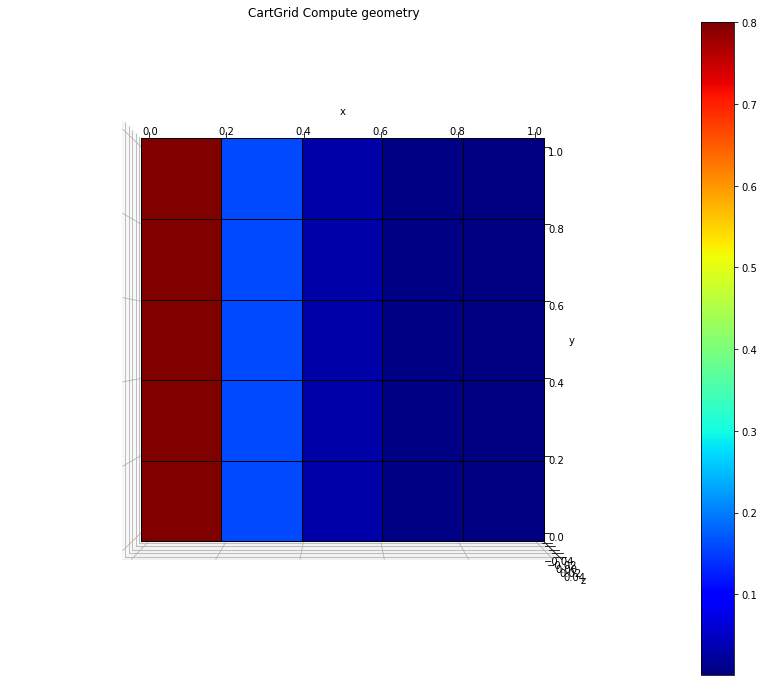

In [9]:
pp.plot_grid(g, tracer, figsize=(15, 12))